# Voxel GC Stats

Quantitatively evaluating the memory consumption and accuracy of our reconstructions post voxel decay.

Goals:
 * Show memory usage goes down with the threshold k
 * Show accuracy is OK, and maybe only goes down a little
 * Show that completeness only goes down a little with super k-s
 * It's probably best to have side-by-side plots of DispNet and ELAS

In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

%matplotlib inline

from matplotlib import rc

# Enable full LaTeX support in plot text. Requires a full-fledged LaTeX installation
# on your system, accessible via PATH.
rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (16, 6)
matplotlib.rcParams.update({'font.size': 20})

In [4]:
root = os.path.join('..', 'csv', 'decay-experiments')

In [5]:
def stitch(base_tpl):
    """Used to stitch together data from multiple CSV dumps.
    
    Useful if you want X frames but the system crashes from a stupid bug
    when you're 99% done.
    """
    components = ['dynamic-depth-result', 'static-depth-result', 'memory']
    bits = ['-A', '-B']
    offsets = [0, 864]
    for c in components:
        curr_frame_off = 0
        curr_memory_off = 0  
        # No need for saved memory tracking since so far we're just stitching sequences with no decay.
        
        cum_df = None
        print("\n\nStarting component: {}".format(c))
        
        for bit, offset in zip(bits, offsets):
            fk = 'frame_id' if c == 'memory' else 'frame'
            fpath = os.path.join(root, base_tpl.format(bit, offset, c))
            df = pd.read_csv(fpath)
            
            print(len(df))
            print("Last:", df[fk].iloc[-1])
            
            print("Adding {} to frame ids by key {}...".format(curr_frame_off, fk))
            df[fk] += curr_frame_off

            if c == 'memory':
                df['memory_usage_bytes'] += curr_memory_off
            
            if cum_df is None:
                cum_df = df
            else:
                cum_df = pd.concat([cum_df, df])
                
            print(c, "Len:", len(cum_df))
           
            curr_frame_off += df[fk].iloc[-1] 
            if c == 'memory':
                curr_memory_off = df['memory_usage_bytes'].iloc[-1]
                print("Mem offset: ", curr_memory_off)
        
        out_fname = base_tpl.format("", 0, c)
        
        out_fpath = os.path.join(root, out_fname)
        cum_df.index = cum_df[fk]
        del cum_df[fk]
        
        cum_df.to_csv(out_fpath)

# stitch("k-0{}-kitti-odometry-09-offset-{}-depth-precomputed-dispnet-voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-NO-fusion-weights-{}.csv")

In [6]:
acc_fname_template = 'k-{}-kitti-odometry-09-offset-0-depth-precomputed-{}-'  \
                     'voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-' \
                     'NO-fusion-weights-static-depth-result.csv'
mem_fname_template = 'k-{}-kitti-odometry-09-offset-0-depth-precomputed-{}-'  \
                     'voxelsize-0.0500-max-depth-m-20.00-dynamic-mode-NO-direct-ref-' \
                     'NO-fusion-weights-memory.csv'        

ks = [0, 1, 2, 3, 5, 8, 10]
depths = ['dispnet', 'elas']

memory = {}
frame_lim = 1000

stats = {
}

for depth in depths:
    memory[depth] = {}
    stats[depth] = {
        'k': [],
        'accuracy': [],
        'completeness': [],
        'f1': [],
        'mem-gb': [],
    }
    
    for k in ks:
        acc_fname = acc_fname_template.format(k, depth)
        mem_fname = mem_fname_template.format(k, depth)
        acc_fpath = os.path.join(root, acc_fname)
        mem_fpath = os.path.join(root, mem_fname)
        BYTE_TO_GB = 1.0 / (1024 * 1024 * 1024)
        
        df_acc = pd.read_csv(acc_fpath)
        df_mem = pd.read_csv(mem_fpath)
        mem_raw = df_mem['memory_usage_bytes'][:frame_lim]
        memory[depth]['$k_\\textrm{{weight}} = {}$'.format(k)] = mem_raw * BYTE_TO_GB

        total_gt = df_acc['fusion-total-3.00-kitti']
        err = df_acc['fusion-error-3.00-kitti'] / (total_gt - df_acc['fusion-missing-3.00-kitti'])
        completeness = (1.0 - df_acc['fusion-missing-separate-3.00-kitti'] / total_gt)
        
        err_m = err.mean()
        acc_m = (1.0 - err).mean()
        com_m = completeness.mean()
        # Not super rigorous, but does combine the two metrics somewhat meaningfully...
        poor_man_f1 = 2 * (acc_m * com_m) / (acc_m + com_m)
        
        stats[depth]['k'].append(k)
        stats[depth]['accuracy'].append(acc_m)
        stats[depth]['completeness'].append(com_m)
        stats[depth]['f1'].append(poor_man_f1)
        stats[depth]['mem-gb'].append(mem_raw[mem_raw.index[-1]] * BYTE_TO_GB)
       

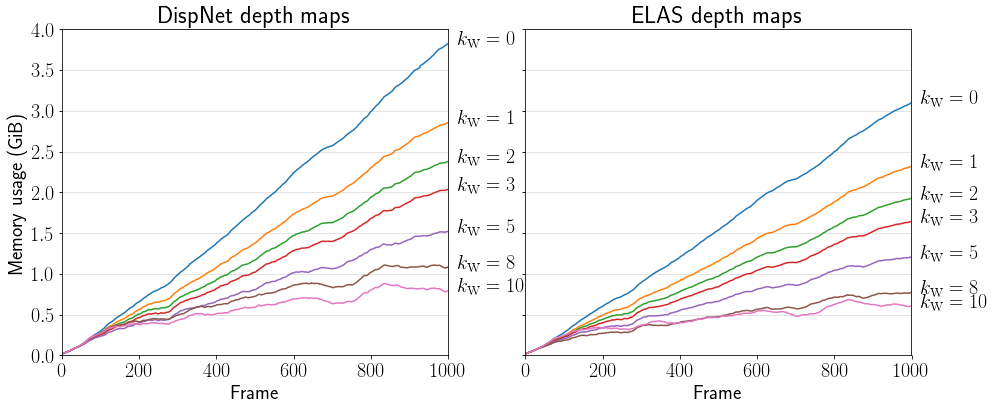

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
ylim = [0, 4.0]

# This is dirty but does the job
ordered_cols = ['$k_\\textrm{{weight}} = {}$'.format(i) for i in ks]

df_disp = pd.DataFrame(memory['dispnet'])
df_disp.plot(y=ordered_cols, ax=ax1, legend=False)
ax1.set_ylim(ylim)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Memory usage (GiB)")
ax1.set_title("DispNet depth maps")
# ax1.legend(loc='upper left')
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)

df_elas = pd.DataFrame(memory['elas'])
df_elas.plot(y=ordered_cols, ax=ax2, legend=False)
ax2.set_ylim(ylim)
ax2.set_xlabel("Frame")
# ax2.set_ylabel("Memory usage (GiB)")
ax2.set_title("ELAS depth maps")
# ax2.legend(loc='upper left')
ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)

for i in ks:
    key = '$k_\\textrm{{weight}} = {}$'.format(i)
    key_short = '$k_\\textrm{{w}} = {}$'.format(i)
    ax1.text(df_disp.index[-1] + 25, df_disp[key].iloc[-1] - 0.05, key_short)
    ax2.text(df_elas.index[-1] + 25, df_elas[key].iloc[-1] - 0.05, key_short)

plt.subplots_adjust(right=1.6)
# fig.suptitle("Memory usage under varying voxel GC thresholds")
# plt.tight_layout()

fig.savefig('../fig/recon-over-time.eps', bbox_inches='tight')
fig.savefig('../fig/recon-over-time.png', bbox_inches='tight')


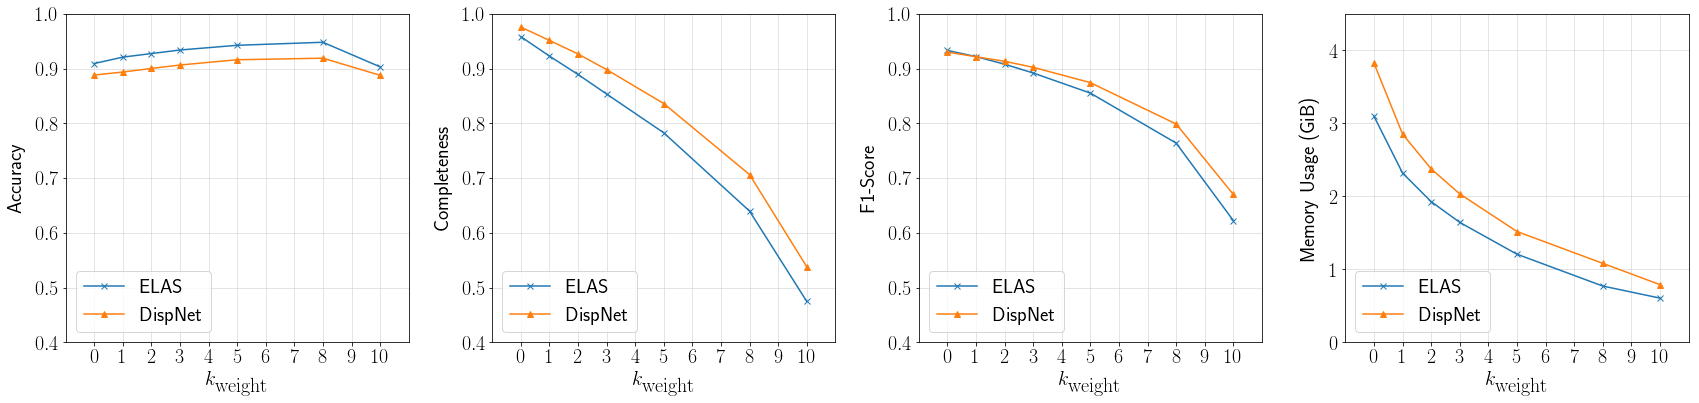

In [9]:
mem_col = 'C3'

# Quad-plot = default, in thesis.
# Non-quad, i.e., line => saves a tiny bit of space for the paper
quad_plot = False

if quad_plot:
    ROWS = 2
    COLS = 2
else:
    ROWS = 1
    COLS = 4

y_names = {
    'accuracy': 'Accuracy',
    'completeness': 'Completeness',
    'f1': 'F1-Score',
    'mem-gb': 'Memory Usage (GiB)'
}

MAX_GB = 4.5

def mk_acc_mem_plot(ax, stats, depth, key, label):
    ax.plot(stats[depth]['k'], stats[depth][key], label=label)
    ax_mem = ax.twinx()
    mem = np.array(stats[depth]['mem-gb'])
    
    ax_mem.bar(stats[depth]['k'], mem, label="Memory Usage", 
               color=mem_col, fill=True, alpha=0.5)

    ax_mem.set_ylabel('Memory Usage (GiB)', color=mem_col, labelpad=15)
    ax_mem.set_ylim([0, MAX_GB])
    for i, v in enumerate(mem):
        ax_mem.text(stats[depth]['k'][i] - 0.65, v + 0.05, "{:.1f} GiB".format(v),
                    color=mem_col, fontdict={'size': 12})
        
    ax.set_ylim([0.4, 1.0])
    ax.set_xlim([-1, 11])
    ax.set_xticks(np.arange(0, 11))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)
    
#     handles1, labels1 = ax.get_legend_handles_labels()
#     l = plt.legend(handles1, labels1, loc='lower left')
#     ax_mem.add_artist(l)  # Make the legend stay on top
    
    ax.set_ylabel(y_names[key], labelpad=10, color='C0')
    ax.set_xlabel("$k_\\textrm{weight}$")
    ax.set_title(label)

keys = ['accuracy', 'completeness', 'f1', 'mem-gb']
# for key in keys:#, 'mem-gb']):
#     fig, (ax_d, ax_e) = plt.subplots(1, 2, figsize=(12, 4))
    
#     mk_acc_mem_plot(ax_d, stats, 'dispnet', key, "DispNet")
#     mk_acc_mem_plot(ax_e, stats, 'elas', key, "ELAS")
    
fig, axes = plt.subplots(ROWS, COLS, figsize=(6 * COLS, 6 * ROWS))
for ax, key in zip(np.ravel(axes), keys):
    ax.plot(stats['elas']['k'], stats['elas'][key], '-x', label='ELAS')
    ax.plot(stats['dispnet']['k'], stats['dispnet'][key], '-^', label='DispNet')
    
    ax.set_xlabel("$k_\\textrm{weight}$")
    ax.set_ylabel(y_names[key], labelpad=10)
    
    if key != 'mem-gb':
        ax.set_ylim([0.4, 1.0])
    else:
        ax.set_ylim(0, MAX_GB)
        
    ax.set_xlim([-1, 11])
    ax.set_xticks(np.arange(0, 11))
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)
    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.75)
    ax.legend(loc='lower left')

    
#     left  = 0.125  # the left side of the subplots of the figure
#     right = 0.9    # the right side of the subplots of the figure
#     bottom = 0.1   # the bottom of the subplots of the figure
#     top = 0.9      # the top of the subplots of the figure
#     wspace = 0.2   # the amount of width reserved for blank space between subplots,
#                    # expressed as a fraction of the average axis width
#     hspace = 0.2   # the amount of height reserved for white space between subplots,
#                    # expressed as a fraction of the average axis height
#     fig.subplots_adjust(hspace = 0.5)

fig.tight_layout()
name = 'recon-acc-quad'#.format(key)
fig.savefig('../fig/{}.eps'.format(name), bbox_inches='tight')
fig.savefig('../fig/{}.png'.format(name), bbox_inches='tight')